# Portfolio Optimization with Hierarchical Risk Parity (HRP)

## Dependencies


In [45]:
# ! pip install --upgrade yfinance plotly nbformat seaborn scipy --quiet

In [46]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.cluster.hierarchy as sch
from scipy.optimize import minimize

import yfinance as yf

import plotly.graph_objects as go
import plotly.figure_factory as ff

In [47]:
# plt.style.available # Review available styles

# Set plotting style for better visuals in Jupyter
plt.style.use('tableau-colorblind10') 
sns.set_palette("husl")

%matplotlib inline

np.random.seed(42)  # For reproducibility

## Define the assets for the portfolio (mix of stocks, ETFs, and bonds)


In [48]:
# tickers = [
#     "AAPL",  # Apple (Technology)
#     "MSFT",  # Microsoft (Technology)
#     "JPM",  # JPMorgan Chase (Financials)
#     "XOM",  # ExxonMobil (Energy)
#     "SPY",  # S&P 500 ETF (Broad Market)
#     "TLT",  # iShares 20+ Year Treasury Bond ETF (Bonds)
#     "GLD",  # SPDR Gold Shares (Commodities)
# ]

tickers = [
    "SPY",  # S&P 500 ETF (Broad Market)
    "BND",  # Vanguard Total Bond Market ETF (Bonds)
    "GLD",  # SPDR Gold Shares (Commodities)
    "QQQ",  # Invesco QQQ ETF (Technology)
    "VTI",  # Vanguard Total Stock Market ETF (Broad Market)
]

# Define the date range (5 years of historical data)
end_date = datetime.now()  # Current date
start_date = end_date - timedelta(days=15 * 365)  # 10 years ago

print(f"Fetching data from {start_date} to {end_date}")

Fetching data from 2010-04-14 01:26:20.540302 to 2025-04-10 01:26:20.540302


## Fetch Historical Data


In [49]:
def fetch_yfinance_data(tickers, start_date, end_date):
    try:
        # Fetch data using yfinance
        data = yf.download(
            tickers,
            start=start_date,
            end=end_date,
            auto_adjust=False,
            progress=True,
            group_by="ticker",
        )

        # Extract only the "Adj Close" prices
        if isinstance(data.columns, pd.MultiIndex):
            data = data.xs("Adj Close", axis=1, level=1)
        else:
            data = data[["Adj Close"]]

        # Handle missing data
        if data is None or data.empty:
            raise ValueError("No data retrieved. Check ticker symbols or date range.")

        # Forward-fill any remaining NaNs (e.g., for holidays)
        data = data.ffill().dropna()

        return data

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()
    
historical_prices = fetch_yfinance_data(tickers, start_date, end_date)

[*********************100%***********************]  5 of 5 completed


In [50]:
display(historical_prices.head())

Ticker,GLD,VTI,QQQ,SPY,BND
Date,,,,,
2010-04-14,113.029999,47.310814,43.576130,92.094597,51.515911
2010-04-15,113.650002,47.371902,43.768200,92.170609,51.594021
2010-04-16,111.239998,46.631126,43.244343,90.703957,51.704773
2010-04-19,111.150002,46.753315,43.218163,91.045937,51.639629
2010-04-20,111.459999,47.196251,43.436436,91.859009,51.691719


## Data Preprocessing


Preprocess price data to compute daily returns and handle missing values.


In [51]:
def preprocess_data(prices_df):
    # Ensure no missing data
    prices_df = prices_df.dropna()

    # Compute daily returns (percentage change)
    returns_df = prices_df.pct_change().dropna()

    return prices_df, returns_df


# Preprocess the data
prices_df, returns_df = preprocess_data(historical_prices)

# Display summary statistics
print("\nReturns Summary Statistics:")
display(returns_df.describe())


Returns Summary Statistics:


Ticker,GLD,VTI,QQQ,SPY,BND
count,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000
mean,0.000293,0.000524,0.000715,0.000534,0.000096
std,0.009744,0.011226,0.013156,0.010971,0.003075
min,-0.087808,-0.113808,-0.119788,-0.109424,-0.054385
25%,-0.004763,-0.003991,-0.004921,-0.003745,-0.001361
50%,0.000497,0.000745,0.001144,0.000654,0.000228
75%,0.005501,0.005865,0.007355,0.005788,0.001664
max,0.049038,0.101456,0.120031,0.105019,0.042201


## Data Visualisation


Plot normalized prices


In [52]:
normalized_prices = prices_df / prices_df.iloc[0]

fig = go.Figure()

for ticker in normalized_prices.columns:
    fig.add_trace(
        go.Scatter(
            x=normalized_prices.index,
            y=normalized_prices[ticker],
            mode="lines",
            name=ticker,
        )
    )

fig.update_layout(
    title="Normalized Asset Prices (2019–2025)",
    xaxis_title="Date",
    yaxis_title="Normalized Price",
    template="plotly_dark",
    legend_title="Tickers",
)
fig.show()

Plot correlation matrix of returns


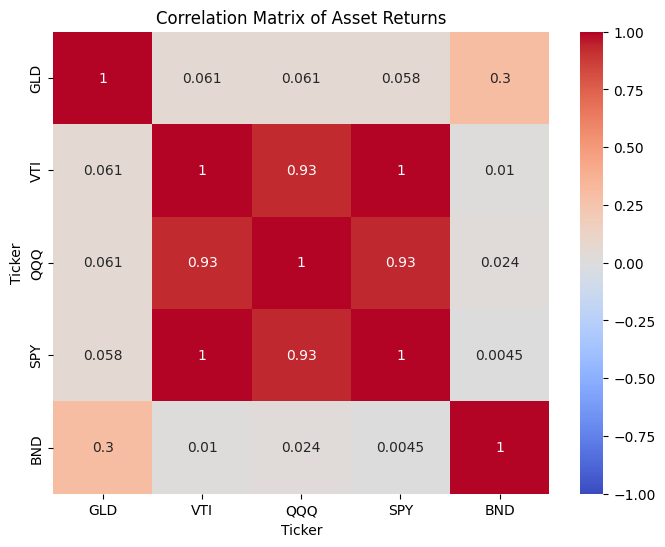

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(returns_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of Asset Returns")
plt.show()

Plot rolling volatility (21-day standard deviation of returns)


In [54]:
rolling_volatility = returns_df.rolling(window=21).std() * np.sqrt(252)  # Annualized

fig = go.Figure()

for ticker in rolling_volatility.columns:
    fig.add_trace(
        go.Scatter(
            x=rolling_volatility.index,
            y=rolling_volatility[ticker],
            mode="lines",
            name=ticker,
        )
    )

fig.update_layout(
    title="21-Day Rolling Volatility (Annualized)",
    xaxis_title="Date",
    yaxis_title="Volatility",
    template="plotly_dark",
    legend_title="Tickers",
)
fig.show()

## Save Data for Portfolio Optimization


Save prices and returns to CSV for reusability


In [55]:
os.makedirs("data", exist_ok=True)

prices_df.to_csv("data/portfolio_prices.csv")
returns_df.to_csv("data/portfolio_returns.csv")

print("\nData saved to 'portfolio_prices.csv' and 'portfolio_returns.csv'")


Data saved to 'portfolio_prices.csv' and 'portfolio_returns.csv'


In [56]:
print(f"\nFinal Prices DataFrame Shape: {prices_df.shape}")
print(f"Final Returns DataFrame Shape: {returns_df.shape}")


Final Prices DataFrame Shape: (3772, 5)
Final Returns DataFrame Shape: (3771, 5)


## Log Normal Daily Returns

In [57]:
# Compute log-normal daily returns
log_returns = np.log(prices_df / prices_df.shift(1)).dropna()

# Display summary statistics
print("\nLog-Normal Returns Summary Statistics:")
display(log_returns.describe())

print("\nLog-Normal Returns:")
display(log_returns.head())


Log-Normal Returns Summary Statistics:


Ticker,GLD,VTI,QQQ,SPY,BND
count,3771.000000,3771.000000,3771.000000,3771.000000,3771.000000
mean,0.000246,0.000460,0.000628,0.000473,0.000091
std,0.009763,0.011252,0.013174,0.010993,0.003080
min,-0.091905,-0.120822,-0.127592,-0.115886,-0.055920
25%,-0.004774,-0.003999,-0.004933,-0.003752,-0.001362
50%,0.000496,0.000744,0.001143,0.000654,0.000228
75%,0.005486,0.005847,0.007328,0.005772,0.001663
max,0.047874,0.096633,0.113356,0.099863,0.041335



Log-Normal Returns:


Ticker,GLD,VTI,QQQ,SPY,BND
Date,,,,,
2010-04-15,0.005470,0.001290,0.004398,0.000825,0.001515
2010-04-16,-0.021434,-0.015761,-0.012041,-0.016040,0.002144
2010-04-19,-0.000809,0.002617,-0.000606,0.003763,-0.001261
2010-04-20,0.002785,0.009429,0.005038,0.008891,0.001008
2010-04-21,0.007597,-0.000809,0.005613,-0.001821,0.000755


## Portfolio Metrics

Calculate Annual Return, Standard Deviation, Minimum Weight, Maximum Weight, and Optimal Weight

In [58]:
corr_matrix = log_returns.corr()

# Convert to distance matrix
dist_matrix = np.sqrt(0.5 * (1 - corr_matrix))

# Perform hierarchical clustering
linkage = sch.linkage(dist_matrix, method='single')  # Single linkage is common for HRP

/var/folders/kd/9h3yrkps2vj0t9zs17vt349c0000gn/T/ipykernel_12391/2386372733.py:7: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



Plot the dendrogram

In [59]:
fig = ff.create_dendrogram(
    dist_matrix.values,
    orientation='left',
    labels=dist_matrix.columns.tolist(),
    linkagefun=lambda x: linkage
)
fig.update_layout(
    title="Hierarchical Clustering Dendrogram",
    xaxis_title="Distance",
    yaxis_title="Assets",
    template="plotly_dark"
)
fig.show()

In [60]:
# HRP weight allocation (simplified recursive bisection)
def get_hrp_weights(corr, cov, linkage):
    n = len(corr)
    weights = pd.Series(1.0, index=corr.index)
    clustered_alphas = sch.leaves_list(linkage)
    
    def get_cluster_var(cov, c_items):
        cov_slice = cov.loc[c_items, c_items]
        ivol = 1 / np.diag(cov_slice) ** 0.5
        w = ivol / ivol.sum()
        return w.dot(cov_slice).dot(w)
    
    def recursive_bisection(cov, items):
        if len(items) <= 1:
            return weights[items]
        mid = len(items) // 2
        c1, c2 = items[:mid], items[mid:]
        var1 = get_cluster_var(cov, c1)
        var2 = get_cluster_var(cov, c2)
        alpha = 1 - var1 / (var1 + var2)
        weights[c1] *= alpha
        weights[c2] *= 1 - alpha
        recursive_bisection(cov, c1)
        recursive_bisection(cov, c2)
        return weights
    
    return recursive_bisection(cov, corr.index[clustered_alphas])

cov_matrix = log_returns.cov() * 252  # Annualized covariance
hrp_weights = get_hrp_weights(corr_matrix, cov_matrix, linkage)


In [61]:
# Step 5: Adjust weights to 20%-40% constraints
optimal_weights = hrp_weights.copy()
optimal_weights = np.clip(optimal_weights, 0.20, 0.40)
optimal_weights /= optimal_weights.sum()  # Normalize to sum to 1

In [62]:
# Compile results with other metrics
annual_returns = log_returns.mean() * 252
std_dev = log_returns.std() * np.sqrt(252)
results = pd.DataFrame({
    "Security": tickers,
    "Annual Return": annual_returns,
    "Standard Deviation": std_dev,
    "Minimum Weight": 0.20,
    "Maximum Weight": 0.40,
    "Optimal Weight": optimal_weights
})

display(results)

,Security,Annual Return,Standard Deviation,Minimum Weight,Maximum Weight,Optimal Weight
Ticker,,,,,,
GLD,SPY,0.061892,0.154987,0.2,0.4,0.166667
VTI,BND,0.116012,0.178624,0.2,0.4,0.166667
QQQ,GLD,0.158355,0.209127,0.2,0.4,0.166667
SPY,QQQ,0.119257,0.174513,0.2,0.4,0.166667
BND,VTI,0.023000,0.048889,0.2,0.4,0.333333


In [63]:
# Define the risk-free rate (current 10yr US Treasury yield)
risk_free_rate = 4.30 / 100  # 4.30% annualized

# Calculate portfolio expected return
expected_return = (optimal_weights * annual_returns).sum()

# Calculate portfolio standard deviation
portfolio_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

# Calculate total weight
total_weight = optimal_weights.sum()

# Calculate Sharpe ratio
sharpe_ratio = (expected_return - risk_free_rate) / portfolio_std_dev

# Display portfolio summary
print("Portfolio Summary:")
print(f"Expected Return: {expected_return * 100:.2f}%")
print(f"Standard Deviation: {portfolio_std_dev * 100:.2f}%")
print(f"Risk-Free Rate: {risk_free_rate * 100:.2f}%")
print(f"Total Weight: {total_weight * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio * 100:.2f}%")

Portfolio Summary:
Expected Return: 8.36%
Standard Deviation: 10.00%
Risk-Free Rate: 4.30%
Total Weight: 100.00%
Sharpe Ratio: 40.57%


## Sharpe ratio maximization

In [64]:
# Define the objective function (negative Sharpe ratio)
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negative because we want to maximize Sharpe ratio

# Constraints: weights sum to 1, and each weight is between 0 and 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1) for _ in range(len(tickers))]

# Initial guess for weights (equal allocation)
initial_weights = np.array([1 / len(tickers)] * len(tickers))

# Optimize
optimized_result = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(annual_returns.values, cov_matrix.values, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract optimal weights
optimal_weights_sharpe = optimized_result.x

# Display results
print("Optimal Weights to Maximize Sharpe Ratio:")
for ticker, weight in zip(tickers, optimal_weights_sharpe):
    print(f"{ticker}: {weight:.4f}")

print(f"\nMaximum Sharpe Ratio: {-optimized_result.fun:.4f}")

Optimal Weights to Maximize Sharpe Ratio:
SPY: 0.1811
BND: 0.0000
GLD: 0.8189
QQQ: 0.0000
VTI: 0.0000

Maximum Sharpe Ratio: 0.5587
